In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Hyperparameter
batch_size = 20
z_dim = 128
learning_rate_gen = 2e-4
learning_rate_dis = 2e-4
max_step = 20000
n_dis = 5
# lambda (gradient panelty)
lam = 10.

from data_utils_batch import *
data_X = labelDataReader('../data/animate_label_twingan/')
batch_x, batch_y = data_X.next_batch(100)
f_dim = batch_y.shape[1]
print ('label dimension:', f_dim)
print ('data range:', np.max(batch_x), np.min(batch_x))

kernel_init = tf.random_normal_initializer(stddev = 0.02)

label dimension: 51
data range: 0.32220891869149304 -0.7596269875073646


In [3]:
def residual_block(x, filters = 64):
    conv1 = tf.layers.conv2d(x, 
                             filters = filters,
                             kernel_size = 3,
                             strides = 1,
                             padding = 'same',
                             kernel_initializer = kernel_init)
    conv1 = tf.layers.batch_normalization(conv1)
    conv1 = tf.nn.relu(conv1)
    
    conv2 = tf.layers.conv2d(conv1,
                             filters = filters,
                             kernel_size = 3,
                             strides = 1,
                             padding = 'same',
                             kernel_initializer = kernel_init)
    conv2 = tf.layers.batch_normalization(conv2)
    
    return tf.add(x, conv2)

def pixel_shuffle(I, r):
    bsize, a, b, c = I.get_shape().as_list()
    X = tf.reshape(I, (-1, a, b, r, r))
    X = tf.split(X, a, 1)  # a, [bsize, b, r, r]
    X = tf.concat([tf.squeeze(x) for x in X], 2)  # bsize, b, a*r, r
    X = tf.split(X, b, 1)  # b, [bsize, a*r, r]
    X = tf.concat([tf.squeeze(x) for x in X], 2)  # bsize, a*r, b*r
    return tf.reshape(X, (-1, a*r, b*r, 1))

def PS(X, r):
    Xc = tf.split(X, X.get_shape()[3] // (r ** 2), 3)
    X = tf.concat([pixel_shuffle(x, r) for x in Xc], 3)
    return X

def resize_block(x, filters):
    out = tf.layers.conv2d(x,
                           filters = filters,
                           kernel_size = 3,
                           strides = 1,
                           padding = 'same',
                           kernel_initializer = kernel_init)
    out = PS(out, 2)
    out = tf.layers.batch_normalization(out)
    return tf.nn.relu(out)

In [4]:
# Define Generator Network
def generator(x, label, reuse = False):
    with tf.variable_scope('generator', reuse = reuse):
        data = tf.concat([x, label], axis = 1)
        fc1 = tf.layers.dense(data, 
                              units = 6 * 6 * 256, 
                              activation = tf.nn.leaky_relu,
                              kernel_initializer = kernel_init)
        fc1 = tf.layers.batch_normalization(fc1)
        fc1 = tf.reshape(fc1, [-1, 6, 6, 256])

        # First Convolutional Layer
        conv1 = tf.layers.conv2d_transpose(fc1, 
                                           filters = 128, 
                                           kernel_size = 5,
                                           strides = 2,
                                           padding = 'same',
                                           activation = tf.nn.leaky_relu,
                                           kernel_initializer = kernel_init)
        conv1 = tf.layers.batch_normalization(conv1)

        res_blocks = []
        res_blocks.append(conv1)
        for i in range(4):
            res_blocks.append(residual_block(res_blocks[i], filters = 128))
            
            
        resize1 = resize_block(res_blocks[-1], filters = 128)
        resize2 = resize_block(resize1, filters = 128)
        resize3 = resize_block(resize2, filters = 128)
        
        # Third Convolutional Layer (Output Layer with tanh activation)
        output = tf.layers.conv2d_transpose(resize3, 
                                            filters = 3, 
                                            kernel_size = 9, 
                                            strides = 1,
                                            padding = 'same',
                                            activation = tf.nn.tanh,
                                            kernel_initializer = kernel_init)
        return output

# test
# z_input = tf.placeholder(tf.float32, shape = [None, z_dim], name = 'gen_input')
# generator(z_input)

In [5]:
def discriminator(x, label, reuse = False):
    with tf.variable_scope('discriminator', reuse = reuse):
        
        # conv1: 48 * 48 * 64
        conv1 = tf.layers.conv2d(x,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv1 = tf.layers.batch_normalization(conv1)
        
        
        # conv2: 24 * 24 * 64
        conv2 = tf.layers.conv2d(conv1,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv2 = tf.layers.batch_normalization(conv2)
        
        # Residual Blocks
        res1 = residual_block(conv2, filters = 64)
        res2 = residual_block(res1, filters = 64)
        # res3 = residual_block(res2, filters = 64)
        
        # conv3: 12 * 12 * 64
        conv3 = tf.layers.conv2d(res2,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        
        conv3 = tf.layers.batch_normalization(conv3)
        
        # res3_1 = residual_block(conv3, filters = 64)
        # res3_2 = residual_block(res3_1, filters = 64)
        
        
        res3 = tf.layers.flatten(conv3)
        res3 = tf.concat([res3, label], axis = 1)
        
        # fc1: 128 units
        fc1 = tf.layers.dense(res3, 
                              units = 128,
                              activation = tf.nn.leaky_relu)
        output = tf.layers.dense(fc1,
                                units = 1)
        return output

In [6]:
# Input
gen_input = tf.placeholder(tf.float32, shape = [None, z_dim - f_dim], name = 'gen_input')
dis_input = tf.placeholder(tf.float32, shape = [None, 96, 96, 3], name = 'dis_input')
lab_input = tf.placeholder(tf.float32, shape = [None, f_dim], name = 'lab_input')
fake_input = generator(gen_input, lab_input)

# Logits
true_logit = discriminator(dis_input, lab_input)
fake_logit = discriminator(fake_input, lab_input, reuse = True)
dis_loss = tf.reduce_mean(fake_logit - true_logit)
gen_loss = tf.reduce_mean(- fake_logit)

# Variables
gen_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
dis_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

## Gradient Penalty

# Generate Interpolated Samples
uniform_dist = tf.contrib.distributions.Uniform(low=0., high=1.)
alpha = uniform_dist.sample((batch_size, 1, 1, 1))
interpolated = dis_input + alpha * (fake_input - dis_input)

# Calculate Gradients
int_logit = discriminator(interpolated, lab_input, reuse = True)
gradients = tf.gradients(int_logit, [interpolated, ])[0]
gradients_l2 = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis = [1, 2, 3]))

# Panelty
gradient_penalty = lam * tf.reduce_mean(tf.square(gradients_l2 - 1.))
dis_loss += gradient_penalty

# Optimizer (RMSProp) RMSPropOptimizer
gen_opt = tf.train.AdamOptimizer(learning_rate_gen, beta1=0.5).minimize(gen_loss, var_list = gen_var)
dis_opt = tf.train.AdamOptimizer(learning_rate_dis, beta1=0.5).minimize(dis_loss, var_list = dis_var)

# Initialization
init = tf.global_variables_initializer()

Instructions for updating:
Use the retry module or similar alternatives.


In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

model_dir = '../model/'
saver = tf.train.Saver()

for i in range(max_step):
    
    for j in range(n_dis):
        batch_x, batch_y = data_X.next_batch(batch_size)
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
        sess.run([dis_opt], feed_dict = feed_dict)
        
    batch_x, batch_y = data_X.next_batch(batch_size)
    z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
    feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
    _, d_loss, g_loss, p = sess.run([gen_opt, dis_loss, gen_loss, gradient_penalty], feed_dict = feed_dict)
    if i % 400 == 0:
        print ('step {}: {}, {}, {}'.format(i, d_loss, g_loss, p))
        print ('step {}: {} (fake_logit - true_logit)'.format(i, d_loss - p))
        saver.save(sess, model_dir + 'cgan', global_step = i)

step 0: 2.023167133331299, 0.024208907037973404, 5.0114545822143555
step 0: -2.9882874488830566 (fake_logit - true_logit)
step 400: -29.31195068359375, -24.59345054626465, 9.090935707092285
step 400: -38.40288543701172 (fake_logit - true_logit)
step 800: -13.196065902709961, -19.377513885498047, 4.224619388580322
step 800: -17.420684814453125 (fake_logit - true_logit)
step 1200: -15.647807121276855, -7.791333198547363, 3.5279340744018555
step 1200: -19.17574119567871 (fake_logit - true_logit)
step 1600: -12.47622013092041, -2.0208349227905273, 2.770972490310669
step 1600: -15.2471923828125 (fake_logit - true_logit)
step 2000: -13.977335929870605, -3.5196640491485596, 2.408961296081543
step 2000: -16.38629722595215 (fake_logit - true_logit)
step 2400: -12.558062553405762, -0.5241197347640991, 2.2537834644317627
step 2400: -14.811845779418945 (fake_logit - true_logit)
step 2800: -13.055063247680664, 3.4931273460388184, 2.367152214050293
step 2800: -15.422215461730957 (fake_logit - true_l

In [ ]:
continue_train = True

if continue_train:

    for i in range(max_step, max_step * 2):

        for j in range(n_dis):
            batch_x, batch_y = data_X.next_batch(batch_size)
            z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
            feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
            sess.run([dis_opt], feed_dict = feed_dict)

        batch_x, batch_y = data_X.next_batch(batch_size)
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
        _, d_loss, g_loss, p = sess.run([gen_opt, dis_loss, gen_loss, gradient_penalty], feed_dict = feed_dict)
        if i % 400 == 0:
            print ('step {}: {}, {}, {}'.format(i, d_loss, g_loss, p))
            print ('step {}: {} (fake_logit - true_logit)'.format(i, d_loss - p))
            saver.save(sess, model_dir + 'cgan', global_step = i)

step 20000: -8.073343276977539, 4.413426399230957, 1.3785746097564697
step 20000: -9.45191764831543 (fake_logit - true_logit)
step 20400: -3.956758975982666, -1.5070552825927734, 0.6490534543991089
step 20400: -4.6058125495910645 (fake_logit - true_logit)


In [13]:
continue_train_2 = True

if continue_train_2:

    for i in range(max_step * 2, max_step * 3):

        for j in range(n_dis):
            batch_x, batch_y = data_X.next_batch(batch_size)
            z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
            feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
            sess.run([dis_opt], feed_dict = feed_dict)

        batch_x, batch_y = data_X.next_batch(batch_size)
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
        _, d_loss, g_loss, p = sess.run([gen_opt, dis_loss, gen_loss, gradient_penalty], feed_dict = feed_dict)
        if i % 400 == 0:
            print ('step {}: {}, {}, {}'.format(i, d_loss, g_loss, p))
            print ('step {}: {} (fake_logit - true_logit)'.format(i, d_loss - p))
            saver.save(sess, model_dir + 'cgan', global_step = i)

step 40000: -1.3420213460922241, 147.3627166748047, 0.12335267663002014
step 40000: -1.4653739929199219 (fake_logit - true_logit)
step 40400: -7.537594318389893, -48.79182434082031, 0.30282318592071533
step 40400: -7.840417385101318 (fake_logit - true_logit)
step 40800: -3.6125359535217285, 105.80067443847656, 0.0820784643292427
step 40800: -3.6946144104003906 (fake_logit - true_logit)
step 41200: -8.328255653381348, 173.28530883789062, 0.29461249709129333
step 41200: -8.622868537902832 (fake_logit - true_logit)
step 41600: -3.140197515487671, -92.1322021484375, 0.3864513039588928
step 41600: -3.526648759841919 (fake_logit - true_logit)
step 42000: -4.860061168670654, 22.629606246948242, 0.02646835334599018
step 42000: -4.886529445648193 (fake_logit - true_logit)
step 42400: -2.2308120727539062, -1.2430206537246704, 0.11001072078943253
step 42400: -2.340822696685791 (fake_logit - true_logit)
step 42800: -4.353555679321289, 10.943387985229492, 0.15944552421569824
step 42800: -4.51300144

In [9]:
rev_label_dict = {'long_hair': 0, 'short_hair': 1, 'blush': 2, 'smile': 3, 'blonde_hair': 4, 'blue_eyes': 5, 'brown_hair': 6, 'open_mouth': 7, 'hat': 8, 'red_eyes': 9, 'black_hair': 10, 'ribbon': 11, 'twintails': 12, 'brown_eyes': 13, 'blue_hair': 14, 'green_eyes': 15, 'purple_eyes': 16, 'pink_hair': 17, 'purple_hair': 18, 'closed_eyes': 19, 'ponytail': 20, 'green_hair': 21, 'simple_background': 22, 'red_hair': 23, 'yellow_eyes': 24, 'very_long_hair': 25, 'glasses': 26, 'silver_hair': 27, 'one_eye_closed': 28, 'ahoge': 29, 'male': 30, 'white_hair': 31, 'earrings': 32, 'tongue': 33, 'pink_eyes': 34, 'aqua_eyes': 35, 'black_eyes': 36, 'orange_hair': 37, 'aqua_hair': 38, 'grin': 39, 'multicolored_hair': 40, 'dark_skin': 41, 'tongue_out': 42, 'grey_hair': 43, 'drill_hair': 44, 'short_twintails': 45, 'orange_eyes': 46, 'facial_hair': 47, 'grey_eyes': 48, 'two-tone_hair': 49, 'tan': 50}
label_dict = {}
for key in rev_label_dict:
    label_dict[rev_label_dict[key]] = key

mean_rgb = np.array([172.83672573366928, 175.73611140584845, 193.70488181437796])
mean_rgb = mean_rgb / 255.

long_hair, black_hair, purple_eyes, simple_background, 0 0
long_hair, blush, blue_eyes, red_hair, 1 0
short_hair, blush, smile, black_hair, purple_eyes, 2 0
short_hair, red_eyes, blue_hair, 3 0
long_hair, hat, red_eyes, ribbon, blue_hair, 0 1
long_hair, brown_hair, twintails, brown_eyes, simple_background, 1 1
black_hair, closed_eyes, simple_background, 2 1
short_hair, blush, green_eyes, pink_hair, simple_background, 3 1
short_hair, blush, smile, blue_eyes, blue_hair, simple_background, 0 2
long_hair, blush, brown_hair, purple_eyes, 1 2
smile, red_eyes, green_hair, 2 2
long_hair, blush, brown_hair, twintails, brown_eyes, 3 2
short_hair, blush, smile, brown_hair, red_eyes, simple_background, 0 3
short_hair, blue_eyes, blue_hair, 1 3
short_hair, black_hair, brown_eyes, 2 3
short_hair, blush, smile, blue_eyes, black_hair, simple_background, 3 3
long_hair, blue_eyes, ribbon, silver_hair, 0 4
short_hair, blush, purple_eyes, red_hair, 1 4
short_hair, green_eyes, purple_hair, 2 4
long_hair, r

/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


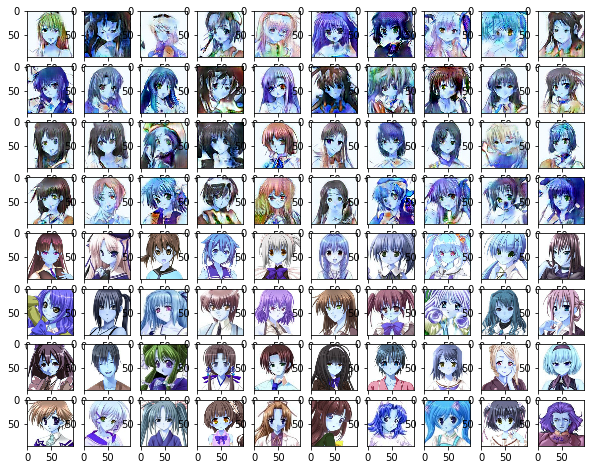

In [12]:
# Generate images from noise, using the generator network.
cnt = 0

f, a = plt.subplots(8, 10, figsize=(10, 8))
for i in range(10):
    # Noise input.
    z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
    
    batch_x, batch_y = data_X.next_batch(batch_size)
    
    batch_x = batch_x + mean_rgb
    
    g = sess.run(fake_input, feed_dict={gen_input: z, lab_input: batch_y})
    
    g = g + mean_rgb
    g[g > 1.] = 1.
    g[g < 0.] = 0.
        
    for j in range(4):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        cv2.imwrite('../result/{}.jpg'.format(str(cnt).zfill(3)), g[j] * 255)
        a[j][i].imshow(g[j])
        a[j + 4][i].imshow(batch_x[j])
        cnt += 1
        
        for k in range(batch_y.shape[1]):
            if batch_y[j][k] == 1:
                print (label_dict[k], end = ', ')
        print (j, i)
f.show()
plt.draw()